# ICLR Paper Dataset Analysis

This notebook analyzes the ICLR paper dataset including:
1. Pipeline breakdown from pickles to clean data
2. Yearly decision breakdown (poster/spotlight/oral/reject)
3. Rating and citation statistics by year
4. Correlation analysis between acceptance, decision, and citations
5. Rating vs acceptance relationship and anomaly detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lib.explore_data_utils import (
    get_hf_dataset_pipeline_stats,
    get_pipeline_stats_2024_2025,
    load_hf_dataset_as_dataframe,
    get_yearly_decision_breakdown,
    get_yearly_rating_stats,
    get_yearly_citation_stats,
    add_normalized_citations,
    add_normalized_ratings,
    encode_decisions,
    compute_correlations,
    analyze_rating_acceptance_relationship,
    get_anomalous_papers,
)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Pipeline Breakdown (from pickles to "clean")

Pipeline stages matching exactly what's in `hf_dataset_new` (each is cumulative subset of previous):

| Column        | Meaning                                                                    |
|---------------|----------------------------------------------------------------------------|
| total         | All submissions in pickle files (get_all_notes_{year}.pickle)              |
| reviewable    | Total minus Withdrawn and Desk Reject (papers that went through review)    |
| has_pdf       | Reviewable + has downloaded PDF file                                       |
| mineru        | has_pdf + has MinerU output (content_list.json)                            |
| valid_md      | mineru + the .md file is > 100 bytes (not empty/corrupted)                 |
| normalized    | valid_md + has normalized output directory with meta.json                  |
| has_abstract  | normalized + meta.has_abstract = True                                      |
| has_references| has_abstract + meta.has_references = True                                  |
| has_content   | has_references + content_list_json length > 0                              |
| valid_images  | has_content + image_count == page_end + 1 and page_end >= 0                |

The final `valid_images` column should match the row count of `hf_dataset_new`.

In [14]:
# Generate pipeline breakdown matching hf_dataset_new exactly
# Note: Pass correct relative paths from notebooks/ directory
print("=== Pipeline Statistics (matching hf_dataset_new) ===")
pipeline_df = get_hf_dataset_pipeline_stats(data_dir="../data/full_run")
display(pipeline_df)

=== Pipeline Statistics (matching hf_dataset_new) ===
Building indices...
  PDF index: 49692 files
  MinerU index: 41780 folders
  Normalized index: 39915 submissions


Processing years: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [37:18<00:00, 319.76s/it]


,year,total,reviewable,has_pdf,mineru,valid_md,normalized,has_abstract,has_references,has_content,valid_images
0,2020,2213,2213,2213,2211,2211,1444,1429,1424,1424,1423
1,2021,2594,2594,2594,2593,2593,2593,2585,2584,2584,2583
2,2022,2617,2617,2617,2617,2617,2617,2608,2602,2602,2602
3,2023,3792,3792,3792,3792,3792,3792,3788,3774,3774,3774
4,2024,7404,5780,5780,5779,5779,4796,4780,4766,4766,4764
5,2025,11672,8727,8727,8727,8727,8727,8718,8680,8680,8671
6,2026,19605,15948,15948,15946,15946,15946,15928,15874,15874,15867
7,Total,49897,41671,41671,41665,41665,39915,39836,39704,39704,39684


### 2024/2025 Pipeline with DeepReview-13K Overlap

Shows pipeline counts with percentage of each stage that exists in DeepReview-13K dataset (for data contamination analysis).

In [ ]:
# Pipeline stats for 2024/2025 with DeepReview-13K overlap percentages
print("=== 2024/2025 Pipeline with DeepReview-13K Overlap ===")
dr_pipeline_df = get_pipeline_stats_2024_2025(data_dir="../data/full_run")
display(dr_pipeline_df)

=== 2024/2025 Pipeline with DeepReview-13K Overlap ===
Loading DeepReview-13K IDs...


## 2. Load HuggingFace Dataset

In [5]:
# Load HF dataset as DataFrame
df = load_hf_dataset_as_dataframe("../data/hf_dataset_new2")
print(f"Loaded {len(df):,} papers")
df.head()

loading from disk
loaded from disk
to_pandas done
Loaded 39,684 papers


,submission_id,year,openreview_link,pdf_download_link,title,original_abstract,no_github_abstract,original_md_path,clean_md_path,images_in_clean_md,clean_pdf_img_paths,original_reviews,normalized_reviews,original_metareview,normalized_metareview,technical_indicators,metadata_of_changes,submission_json,content_list_json,_pdf_path,_mineru_path,_normalized_path,_original_content_list_path,_clean_content_list_path,binary_decision,specific_decision,citations,ratings
0,ryxnJlSKvr,2020,https://openreview.net/forum?id=ryxnJlSKvr,https://openreview.net/pdf/b2abeae9a999f4f2f2f...,SCELMo: Source Code Embeddings from Language M...,Continuous embeddings of tokens in computer pr...,Continuous embeddings of tokens in computer pr...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,"{""2b0012e36586a72d787d752b4a0a2ce9a7f7ac7dfec7...","[""/n/fs/vision-mix/sk7524/NipsIclrData/AutoRev...","[{""rating"": ""3: Weak Reject"", ""review"": ""The p...","[""{\""summary\"":\""The paper applies ELMO embedd...","{""decision"": ""Reject"", ""comment"": ""This paper ...","""{\""summary\"":\""The paper is rejected due to i...","{""binary_decision"": ""reject"", ""specific_decisi...","{""submission_id"": ""ryxnJlSKvr"", ""year"": 2020, ...","{""id"": ""ryxnJlSKvr"", ""forum"": ""ryxnJlSKvr"", ""n...","[{""type"": ""text"", ""text"": ""1 INTRODUCTION"", ""t...",/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,reject,reject,63,"[3, 3, 8]"
1,ryxtWgSKPB,2020,https://openreview.net/forum?id=ryxtWgSKPB,https://openreview.net/pdf/e90a912a0f6b4596f6b...,Quantum Optical Experiments Modeled by Long Sh...,We demonstrate how machine learning is able to...,We demonstrate how machine learning is able to...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,"{""0acaeeb9acd241fef1465cdbbe564e71aaffd1eea521...","[""/n/fs/vision-mix/sk7524/NipsIclrData/AutoRev...","[{""rating"": ""3: Weak Reject"", ""review"": ""This ...","[""{\""summary\"":\""The paper proposes using mach...","{""decision"": ""Reject"", ""comment"": ""The paper p...","""{\""summary\"":\""The paper proposes using RNNs ...","{""binary_decision"": ""reject"", ""specific_decisi...","{""submission_id"": ""ryxtWgSKPB"", ""year"": 2020, ...","{""id"": ""ryxtWgSKPB"", ""forum"": ""ryxtWgSKPB"", ""n...","[{""type"": ""text"", ""text"": ""1 INTRODUCTION"", ""t...",/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,reject,reject,13,"[3, 1, 1]"
2,ryxn8RNtvr,2020,https://openreview.net/forum?id=ryxn8RNtvr,https://openreview.net/pdf/c3ca1b5e3d0b39028dc...,NormLime: A New Feature Importance Metric for ...,The problem of explaining deep learning models...,The problem of explaining deep learning models...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,"{""0c80cfb3347085ccfcbda5e065e41a8ad0916112d93f...","[""/n/fs/vision-mix/sk7524/NipsIclrData/AutoRev...","[{""rating"": ""3: Weak Reject"", ""review"": ""\nThi...","[""{\""summary\"":\""The paper proposes a novel no...","{""decision"": ""Reject"", ""comment"": ""The paper a...","""{\""summary\"":\""The paper proposes NormLIME, a...","{""binary_decision"": ""reject"", ""specific_decisi...","{""submission_id"": ""ryxn8RNtvr"", ""year"": 2020, ...","{""id"": ""ryxn8RNtvr"", ""forum"": ""ryxn8RNtvr"", ""n...","[{""type"": ""text"", ""text"": ""1 INTRODUCTION"", ""t...",/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/N

In [38]:
import json
from lib.normalize_mineru import is_references_header

In [40]:
def verify(row):
    row = df.iloc[0]
    content = row.content_list_json
    content_json = json.loads(content)
    has_references= False
    for item in content_json:
        if is_references_header(item):
            has_references=True
            break
    assert has_referencese

df.apply(verify, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
39679    None
39680    None
39681    None
39682    None
39683    None
Length: 39684, dtype: object

## 3. Yearly Decision Breakdown

In [15]:
# Table: By year - accepted (poster/spotlight/oral) vs rejected
decision_df = get_yearly_decision_breakdown(df)
print("=== Yearly Decision Breakdown ===")
display(decision_df)

=== Yearly Decision Breakdown ===


,year,total,rejected,poster,spotlight,oral,accepted,accept_rate
0,2020,1423,976,344,72,31,447,0.314125
1,2021,2583,1726,690,114,53,857,0.331785
2,2022,2602,1512,862,173,55,1090,0.418909
3,2023,3774,2208,1196,279,91,1566,0.414944
4,2024,4764,2848,1530,313,73,1916,0.402183
5,2025,8671,4979,3102,377,213,3692,0.425787
6,2026,15867,15867,0,0,0,0,0.000000


## 4. Yearly Rating Statistics

In [16]:
# Table: By year - unique rating values
rating_df = get_yearly_rating_stats(df)
print("=== Yearly Rating Statistics ===")
display(rating_df)

=== Yearly Rating Statistics ===


,year,unique_ratings,min_rating,max_rating
0,2020,"[1, 3, 6, 8]",1,8
1,2021,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",1,10
2,2022,"[1, 3, 5, 6, 8, 10]",1,10
3,2023,"[1, 3, 5, 6, 8, 10]",1,10
4,2024,"[1, 3, 5, 6, 8, 10]",1,10
5,2025,"[1, 3, 5, 6, 8, 10]",1,10
6,2026,"[0, 2, 4, 6, 8, 10]",0,10


## 5. Yearly Citation Statistics

In [17]:
# Table: By year - citation min/max/mean/median
citation_df = get_yearly_citation_stats(df)
print("=== Yearly Citation Statistics ===")
display(citation_df)

=== Yearly Citation Statistics ===


,year,count,min,max,mean,median
0,2020,1396,0,8832,114.056590,19.0
1,2021,2545,0,62867,102.677407,14.0
2,2022,2566,0,14155,58.128995,12.0
3,2023,3732,0,2772,35.100482,7.0
4,2024,4719,0,3649,23.240729,3.0
5,2025,8535,0,1156,3.396485,0.0
6,2026,15867,0,0,0.000000,0.0


## 6. Add Normalized Columns

In [18]:
# Add normalized columns
df = add_normalized_citations(df)
df = add_normalized_ratings(df)
df = encode_decisions(df)

print("Added columns:")
print("- citations_normalized_by_year (percentile rank)")
print("- rating_normalized_by_year (percentile rank of mean rating)")
print("- acceptance (0=reject, 1=accept)")
print("- decision_encoded (0=reject, 1=poster, 2=spotlight, 3=oral)")

Added columns:
- citations_normalized_by_year (percentile rank)
- rating_normalized_by_year (percentile rank of mean rating)
- acceptance (0=reject, 1=accept)
- decision_encoded (0=reject, 1=poster, 2=spotlight, 3=oral)


## 7. Correlation Analysis

=== Correlation Matrix ===
(acceptance, decision_encoded, citations_normalized_by_year)


,acceptance,decision_encoded,citations_normalized_by_year
acceptance,1.000000,0.894786,0.411637
decision_encoded,0.894786,1.000000,0.403347
citations_normalized_by_year,0.411637,0.403347,1.000000


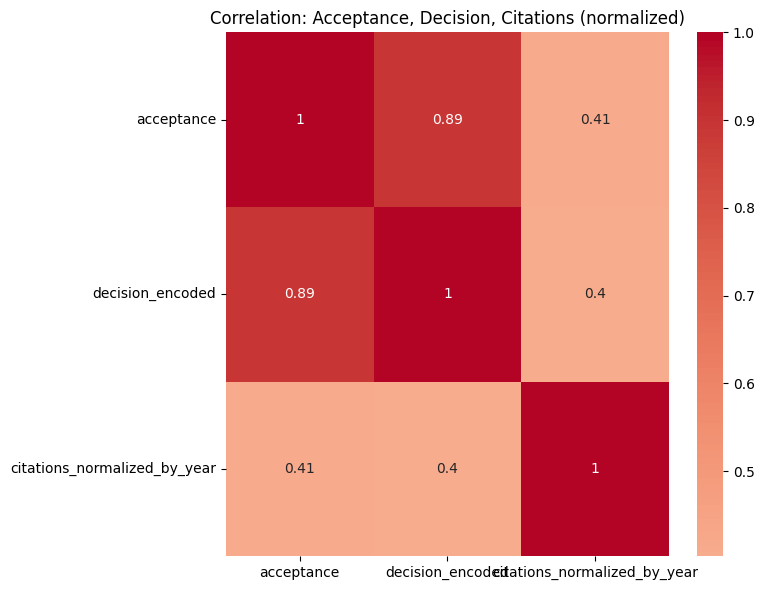

In [19]:
# Correlation between acceptance, decision, citations
corr_matrix = compute_correlations(df)
print("=== Correlation Matrix ===")
print("(acceptance, decision_encoded, citations_normalized_by_year)")
display(corr_matrix)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation: Acceptance, Decision, Citations (normalized)')
plt.tight_layout()
plt.show()

## 8. Rating vs Acceptance Analysis

In [41]:
from lib.explore_data_utils import analyze_rating_citation_relationship

In [23]:
# Analyze rating-acceptance relationship
results = analyze_rating_acceptance_relationship(df)

print("=== Rating vs Acceptance Analysis ===")
print(f"Pearson correlation: {results['correlation']:.4f} (p={results['p_value']:.2e})")
print(f"\nTotal papers analyzed: {results['total_papers']:,}")
print(f"\nAnomalies:")
print(f"  High rating [0.7-1.0] but REJECTED: {results['high_rating_rejected_count']:,} ({results['high_rating_rejected_pct']:.2f}%)")
print(f"  Low rating [0.0-0.3] but ACCEPTED: {results['low_rating_accepted_count']:,} ({results['low_rating_accepted_pct']:.2f}%)")

=== Rating vs Acceptance Analysis ===
Pearson correlation: 0.7603 (p=0.00e+00)

Total papers analyzed: 23,817

Anomalies:
  High rating [0.7-1.0] but REJECTED: 536 (2.25%)
  Low rating [0.0-0.3] but ACCEPTED: 52 (0.22%)


In [48]:
# Analyze rating-acceptance relationship
results = analyze_rating_citation_relationship(df)

print("=== Rating vs Citation Analysis ===")
print(f"Pearson correlation: {results['correlation']:.4f} (p={results['p_value']:.2e})")
print(f"\nTotal papers analyzed: {results['total_papers']:,}")
print(f"\nAnomalies:")
print(f"  High rating [0.7-1.0] but Low Cited: {results['high_rating_low_cite_count']:,} ({results['high_rating_low_cite_pct']:.2f}%)")
print(f"  Low rating [0.0-0.3] but High Cited: {results['low_rating_high_cite_count']:,} ({results['low_rating_high_cite_pct']:.2f}%)")

=== Rating vs Citation Analysis ===
Pearson correlation: 0.4621 (p=0.00e+00)

Total papers analyzed: 23,493

Anomalies:
  High rating [0.7-1.0] but Low Cited: 198 (0.84%)
  Low rating [0.0-0.3] but High Cited: 740 (3.15%)


## 9. Examine Anomalous Papers

In [25]:
# Get high-rated rejected papers
high_rejected = get_anomalous_papers(df, 'high_rating_rejected')
print(f"=== High Rating [>=0.7] but REJECTED: {len(high_rejected)} papers ===")
display(high_rejected[['year', 'submission_id', 'title', 'mean_rating', 'rating_normalized_by_year', 'citations']].sort_values('citations', ascending=False).head(20))

=== High Rating [>=0.7] but REJECTED: 536 papers ===


,year,submission_id,title,mean_rating,rating_normalized_by_year,citations
14219,2024,AL1fq05o7H,Mamba: Linear-Time Sequence Modeling with Sele...,6.250000,0.742338,3100
1314,2020,B1x8anVFPr,On Layer Normalization in the Transformer Arch...,6.000000,0.799368,1258
1277,2020,BJg9hTNKPH,Behavior Regularized Offline Reinforcement Lea...,6.000000,0.799368,871
615,2020,HJlTpCEKvS,Which Tasks Should Be Learned Together in Mult...,6.000000,0.799368,662
620,2020,HJlzxgBtwH,Minimally distorted Adversarial Examples with ...,6.000000,0.799368,604
1318,2020,B1xGGTEtDH,Universal Approximation with Deep Narrow Networks,5.666667,0.718552,513
968,2020,Byg9bxrtwS,Kernel and Rich Regimes in Overparametrized Mo...,5.666667,0.718552,447
302,2020,S1eL4kBYwr,UNITER: Learning UNiversal Image-TExt Represen...,6.000000,0.799368,441
887,2020,BylaUTNtPS,Recurrent Independent Mechanisms,6.000000,0.799368,389
11029,2024,tEAF9LBdgu,AutoGen: Enabling Next-Gen LLM Applications vi...,6.750000,0.871641,315


In [15]:
# Get low-rated accepted papers
low_accepted = get_anomalous_papers(df, 'low_rating_accepted')
print(f"=== Low Rating [<=0.3] but ACCEPTED: {len(low_accepted)} papers ===")
display(low_accepted[['year', 'title', 'mean_rating', 'rating_normalized_by_year', 'citations']].head(10))

=== Low Rating [<=0.3] but ACCEPTED: 52 papers ===


,year,title,mean_rating,rating_normalized_by_year,citations
380,2020,Efficient Probabilistic Logic Reasoning with G...,2.333333,0.121019,167
2720,2021,EEC: Learning to Encode and Regenerate Images ...,4.666667,0.200200,74
6129,2022,Transformer Embeddings of Irregularly Spaced E...,4.750000,0.277564,60
6259,2022,Topologically Regularized Data Embeddings,4.750000,0.277564,10
6293,2022,Neural Program Synthesis with Query,4.666667,0.247791,2
7064,2022,Learning by Directional Gradient Descent,4.500000,0.217057,43
7341,2023,Red PANDA: Disambiguating Image Anomaly Detect...,4.000000,0.134814,4
7461,2023,Contrastive Alignment of Vision to Language Th...,4.666667,0.254560,11
7898,2023,A GNN-Guided Predict-and-Search Framework for ...,4.750000,0.288263,38
8250,2023,Improved Sample Complexity for Reward-free Rei...,4.750000,0.288263,11


In [46]:
# Get high-citation papers (top 30% citations)
df_filtered = df[(df['year'] < 2026)].dropna(subset=['citations_normalized_by_year', 'acceptance'])
high_citation = df_filtered[
    (df_filtered['citations_normalized_by_year'] >= 0.7)
]
print(f"=== High Citation [>=0.7]: {len(high_citation)} papers ===")
display(high_citation[['year', 'submission_id', 'title', 'citations', 'citations_normalized_by_year', 'mean_rating']].sort_values([ 'citations'], ascending=False).head(30))

=== High Citation [>=0.7]: 7022 papers ===


,year,submission_id,title,citations,citations_normalized_by_year,mean_rating
2547,2021,YicbFdNTTy,An Image is Worth 16x16 Words: Transformers fo...,62867,1.000000,7.000000
4490,2022,nZeVKeeFYf9,LoRA: Low-Rank Adaptation of Large Language Mo...,14155,1.000000,7.000000
839,2020,H1eA7AEtvS,ALBERT: A Lite BERT for Self-supervised Learni...,8832,1.000000,7.333333
2792,2021,St1giarCHLP,Denoising Diffusion Implicit Models,8188,0.999613,7.000000
2901,2021,PxTIG12RRHS,Score-Based Generative Modeling through Stocha...,7224,0.999226,8.000000
2180,2021,gZ9hCDWe6ke,Deformable DETR: Deformable Transformers for E...,6958,0.998839,8.000000
4003,2021,-NEXDKk8gZ,Improved Denoising Diffusion Probabilistic Models,4241,0.998451,5.000000
2311,2021,d7KBjmI3GmQ,Measuring Massive Multitask Language Understan...,4192,0.998064,6.250000
4773,2022,gEZrGCozdqR,Finetuned Language Models are Zero-Shot Learners,3956,0.999616,8.000000
14174,2024,AwX6ON5A0V,On Gaussian Mixture Models,3649,1.000000,4.000000


In [35]:
# Get high-citation rejected papers (top 30% citations but rejected)
df_filtered = df[(df['year'] < 2026)].dropna(subset=['citations_normalized_by_year', 'acceptance'])
high_citation_rejected = df_filtered[
    (df_filtered['citations_normalized_by_year'] >= 0.7) & (df_filtered['acceptance'] == 0)
]
print(f"=== High Citation [>=0.7] but REJECTED: {len(high_citation_rejected)} papers ===")
display(high_citation_rejected[['year', 'submission_id', 'title', 'citations', 'citations_normalized_by_year', 'mean_rating']].sort_values('citations_normalized_by_year', ascending=False).head(20))

=== High Citation [>=0.7] but REJECTED: 2378 papers ===


,year,submission_id,title,citations,citations_normalized_by_year,mean_rating
541,2020,SyxS0T4tvS,RoBERTa: A Robustly Optimized BERT Pretraining...,19629,1.000000,6.000000
15882,2024,AwX6ON5A0V,On Gaussian Mixture Models,3649,1.000000,4.000000
15926,2024,AL1fq05o7H,Mamba: Linear-Time Sequence Modeling with Sele...,3100,0.999827,6.250000
20655,2025,YzXPU3QRnL,Larger language models do in-context learning ...,348,0.999520,5.800000
15631,2024,DS5qRs0tQz,Grounding DINO: Marrying DINO with Grounded Pr...,2063,0.999480,6.000000
16600,2024,2ov9RiAkxE,Identifying and Mitigating Vulnerabilities in ...,1867,0.999306,4.500000
25033,2025,0xUEBQV54B,Large Language Monkeys: Scaling Inference Comp...,213,0.999280,5.000000
19714,2025,feFlfuOse1,Gymnasium: A Standard Interface for Reinforcem...,181,0.999040,7.250000
15779,2024,BfMQIJ0nLc,MMBench: Is Your Multi-modal Model an All-arou...,994,0.998959,5.250000
6283,2022,OgCcfc1m0TO,Learning to Prompt for Vision-Language Models,2991,0.998847,4.250000


In [50]:
# Get mid-citation rejected papers (30-40 percentile citations but accepted)
df_filtered = df[(df['year'] < 2026)].dropna(subset=['citations_normalized_by_year', 'acceptance'])
mid_citation_accepted = df_filtered[
    (df_filtered['citations_normalized_by_year'] >= 0.3) & 
    (df_filtered['citations_normalized_by_year'] < 0.4) & 
    (df_filtered['acceptance'] == 1)
]
print(f"=== Mid Citation [0.3-0.4) but ACCEPTED: {len(mid_citation_accepted)} papers ===")
display(mid_citation_accepted[['year', 'submission_id', 'title', 'citations', 'citations_normalized_by_year', 'mean_rating']].sort_values('citations_normalized_by_year', ascending=False).head(20))

=== Mid Citation [0.3-0.4) but ACCEPTED: 1850 papers ===


,year,submission_id,title,citations,citations_normalized_by_year,mean_rating
188,2020,rklk_ySYPB,Provable robustness against all adversarial $l...,6,0.399508,6.666667
459,2020,Hkx7xRVYDr,Duration-of-Stay Storage Assignment under Unce...,6,0.399508,5.000000
1367,2020,B1guLAVFDB,Span Recovery for Deep Neural Networks with Ap...,6,0.399508,5.750000
4435,2022,pN1JOdrSY9,Contrastive Clustering to Mine Pseudo Parallel...,6,0.394312,6.750000
4342,2022,qyTBxTztIpQ,CrowdPlay: Crowdsourcing Human Demonstrations ...,6,0.394312,6.333333
4283,2022,swiyAeGzFhQ,Learning to Guide and to be Guided in the Arch...,6,0.394312,5.500000
6068,2022,CyKHoKyvgnp,Transition to Linearity of Wide Neural Network...,6,0.394312,7.333333
6108,2022,BnQhMqDfcKG,Probabilistic Implicit Scene Completion,6,0.394312,8.000000
6228,2022,9-Rfew334N,Givens Coordinate Descent Methods for Rotation...,6,0.394312,6.000000
6268,2022,7udZAsEzd60,VC dimension of partially quantized neural net...,6,0.394312,6.666667


Data Sampling Testing:
- test filtering out samples where we rejected highly cited papers (7K drop)
- test filtering out sampels where we we accept the bottom 0.3 -0.4 samples of citations (4k drop)
- create a filter on the reviews see which ones are actually helpful

## 10. Visualization: Rating vs Acceptance

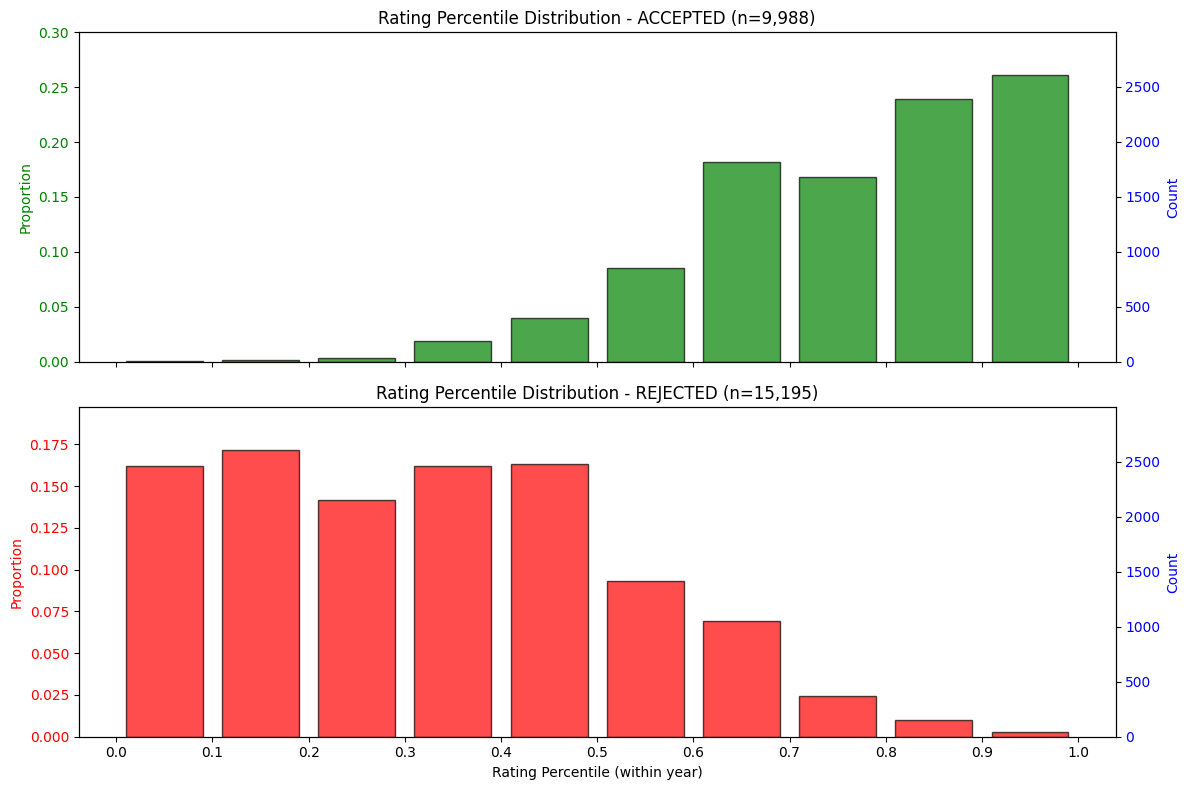

In [33]:
# Rating Percentile Distribution: Accepted vs Rejected (excluding 2026)
df_filtered = df[df['year'] < 2026].dropna(subset=['rating_normalized_by_year'])

accepted = df_filtered[df_filtered['acceptance'] == 1]['rating_normalized_by_year']
rejected = df_filtered[df_filtered['acceptance'] == 0]['rating_normalized_by_year']

bins = np.arange(0, 1.1, 0.1)
bin_centers = bins[:-1] + 0.05

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Accepted papers ---
counts_acc, _ = np.histogram(accepted, bins=bins)
props_acc = counts_acc / len(accepted)

ax1.bar(bin_centers, props_acc, width=0.08, alpha=0.7, color='green', edgecolor='black')
ax1.set_ylabel('Proportion', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title(f'Rating Percentile Distribution - ACCEPTED (n={len(accepted):,})')
ax1.set_ylim(0, max(props_acc) * 1.15)

ax1_right = ax1.twinx()
ax1_right.bar(bin_centers, counts_acc, width=0.08, alpha=0)  # invisible bars for scale
ax1_right.set_ylabel('Count', color='blue')
ax1_right.tick_params(axis='y', labelcolor='blue')
ax1_right.set_ylim(0, max(counts_acc) * 1.15)

# --- Rejected papers ---
counts_rej, _ = np.histogram(rejected, bins=bins)
props_rej = counts_rej / len(rejected)

ax2.bar(bin_centers, props_rej, width=0.08, alpha=0.7, color='red', edgecolor='black')
ax2.set_ylabel('Proportion', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title(f'Rating Percentile Distribution - REJECTED (n={len(rejected):,})')
ax2.set_xlabel('Rating Percentile (within year)')
ax2.set_ylim(0, max(props_rej) * 1.15)

ax2_right = ax2.twinx()
ax2_right.bar(bin_centers, counts_rej, width=0.08, alpha=0)  # invisible bars for scale
ax2_right.set_ylabel('Count', color='blue')
ax2_right.tick_params(axis='y', labelcolor='blue')
ax2_right.set_ylim(0, max(counts_rej) * 1.15)

# Set x-ticks to show bin edges
ax2.set_xticks(bins)
ax2.set_xticklabels([f'{b:.1f}' for b in bins])

plt.tight_layout()
plt.show()

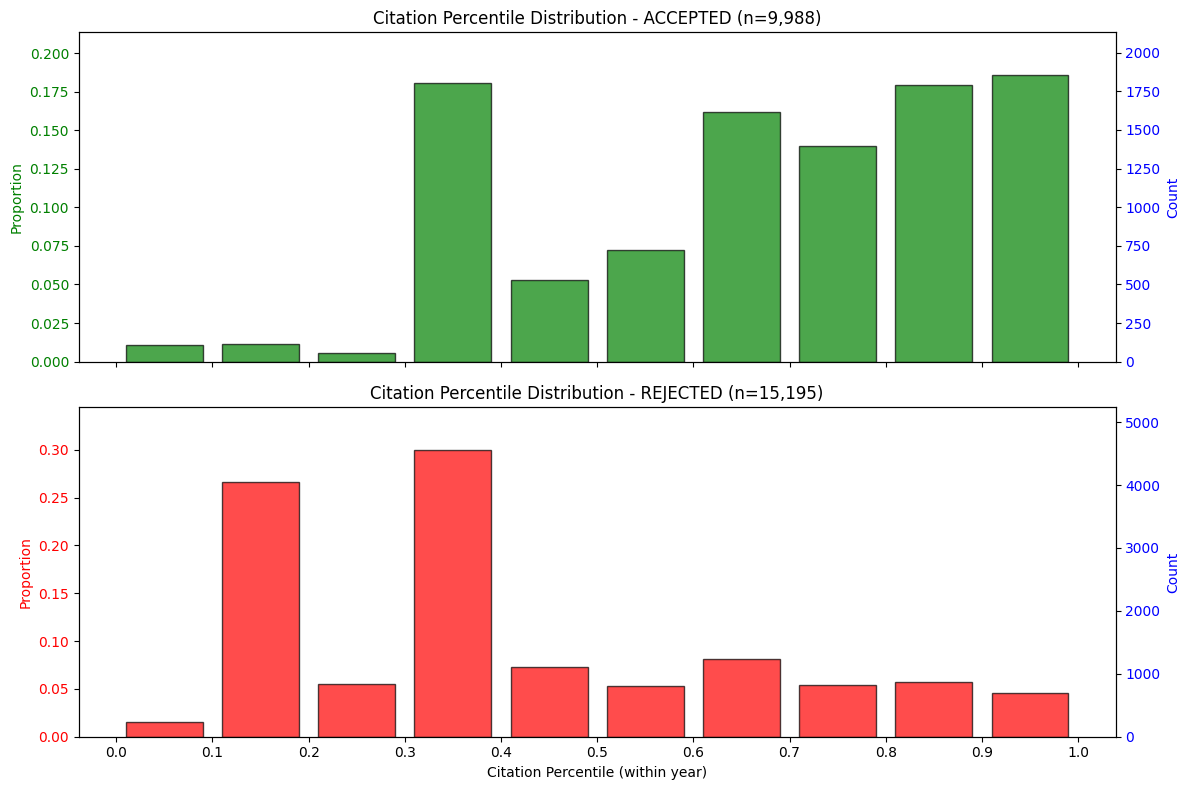

In [34]:
# Citation Percentile Distribution: Accepted vs Rejected (excluding 2026)
df_filtered = df[df['year'] < 2026].dropna(subset=['citations_normalized_by_year'])

accepted = df_filtered[df_filtered['acceptance'] == 1]['citations_normalized_by_year']
rejected = df_filtered[df_filtered['acceptance'] == 0]['citations_normalized_by_year']

bins = np.arange(0, 1.1, 0.1)
bin_centers = bins[:-1] + 0.05

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Accepted papers ---
counts_acc, _ = np.histogram(accepted, bins=bins)
props_acc = counts_acc / len(accepted)

ax1.bar(bin_centers, props_acc, width=0.08, alpha=0.7, color='green', edgecolor='black')
ax1.set_ylabel('Proportion', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title(f'Citation Percentile Distribution - ACCEPTED (n={len(accepted):,})')
ax1.set_ylim(0, max(props_acc) * 1.15)

ax1_right = ax1.twinx()
ax1_right.bar(bin_centers, counts_acc, width=0.08, alpha=0)  # invisible bars for scale
ax1_right.set_ylabel('Count', color='blue')
ax1_right.tick_params(axis='y', labelcolor='blue')
ax1_right.set_ylim(0, max(counts_acc) * 1.15)

# --- Rejected papers ---
counts_rej, _ = np.histogram(rejected, bins=bins)
props_rej = counts_rej / len(rejected)

ax2.bar(bin_centers, props_rej, width=0.08, alpha=0.7, color='red', edgecolor='black')
ax2.set_ylabel('Proportion', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title(f'Citation Percentile Distribution - REJECTED (n={len(rejected):,})')
ax2.set_xlabel('Citation Percentile (within year)')
ax2.set_ylim(0, max(props_rej) * 1.15)

ax2_right = ax2.twinx()
ax2_right.bar(bin_centers, counts_rej, width=0.08, alpha=0)  # invisible bars for scale
ax2_right.set_ylabel('Count', color='blue')
ax2_right.tick_params(axis='y', labelcolor='blue')
ax2_right.set_ylim(0, max(counts_rej) * 1.15)

# Set x-ticks to show bin edges
ax2.set_xticks(bins)
ax2.set_xticklabels([f'{b:.1f}' for b in bins])

plt.tight_layout()
plt.show()

## 11. Citation Percentile Distribution by Year

Histograms showing citation percentile (normalized within each year) with vertical lines for min, max, mean, and median raw citation counts.

In [51]:
# Extract section headers from content_list_json
import json
import re

def is_section_header(item: dict) -> bool:
    """Check if content item is a section header (text_level > 0)."""
    return item.get('type') == 'text' and item.get('text_level', 0) > 0


# Pattern: starts with alphabetical char OR single digit followed by space
VALID_HEADER_PATTERN = re.compile(r'^([A-Za-z]|\d\s)')

def extract_section_headers(content_list_json):
    """Extract section headers that start with alpha char or single digit + space."""
    if pd.isna(content_list_json) or not content_list_json:
        return []
    
    try:
        content_list = json.loads(content_list_json)
        headers = []
        for item in content_list:
            if is_section_header(item):
                text = item.get('text', '').strip()
                if text and VALID_HEADER_PATTERN.match(text):
                    headers.append(text.split(' '))
        return headers
    except (json.JSONDecodeError, TypeError):
        return []

# Apply to dataframe
df['section_headers'] = df['content_list_json'].apply(extract_section_headers)

# Show sample
print(f"Added 'section_headers' column to dataframe")
print(f"Pattern: starts with [A-Za-z] or \\d\\s (single digit + space)")
print(f"\nSample section headers:")
for idx, row in df[df['section_headers'].apply(len) > 0].head(5).iterrows():
    print(f"\n{row['year']} - {row['submission_id']}: {row['title'][:60]}...")
    print(f"  Headers: {row['section_headers']}")

Added 'section_headers' column to dataframe
Pattern: starts with [A-Za-z] or \d\s (single digit + space)

Sample section headers:

2020 - ryxnJlSKvr: SCELMo: Source Code Embeddings from Language Models...
  Headers: ['1 INTRODUCTION', '2 RELATED WORK', '3 EMBEDDINGS FROM LANGUAGE MODELS (ELMO)', '4 SOURCE CODE ELMO', '5 CONTEXTUAL EMBEDDINGS FOR PROGRAM REPAIR', '6 RESULTS', '7 IS NEURAL BUG-FINDING USEFUL IN PRACTICE?', '8 CONCLUSION', 'REFERENCES']

2020 - ryxtWgSKPB: Quantum Optical Experiments Modeled by Long Short-Term Memor...
  Headers: ['1 INTRODUCTION', '2 METHODS', '3 EXPERIMENTS', '4 OUTLOOK', '5 CONCLUSION', 'REFERENCES']

2020 - ryxsUySFwr: Neural Network Out-of-Distribution Detection for Regression ...
  Headers: ['1 INTRODUCTION', '2 RELATED WORK', '3 CHARACTERIZING OOD PREDICTIONS ON REGRESSION TASKS', '4 CHARACTERIZING THE DISTRIBUTION OF HIDDEN FEATURES', '5 OOD DETECTION WITH GENERATIVE MODELS OF HIDDEN FEATURES', '6 EXPERIMENTS', '7 CONCLUSION', 'REFERENCES']

2020 

In [64]:
from pprint import pprint

In [54]:
from collections import defaultdict

section_header_count = defaultdict(lambda: 0)

for ix, row in df.iterrows():
    for header in row.section_headers:
        section_header_count[header] +=1

In [96]:
pprint(
    json.loads(df.loc[df.submission_id == 'KBN6oUx5uL'].content_list_json.iloc[0])
)

[{'bbox': [173, 516, 336, 531],
  'page_idx': 0,
  'text': '1 INTRODUCTION',
  'text_level': 1,
  'type': 'text'},
 {'bbox': [169, 547, 826, 715],
  'page_idx': 0,
  'text': 'In the era of Agentic AI, Large Language Models (LLMs) have evolved '
          'from simple knowledge retrievers to agentic models capable of '
          'completing complex tasks by interacting with their environments '
          '(Schneider, 2025), as exemplified by products like Claude Code '
          '(Anthropic, 2025) and Gemini CLI (Google, 2025). These agents '
          'exhibit many characteristics of human scientists, such as engaging '
          'in long-horizon interaction with environmental feedback, operating '
          'with autonomy, and relying less on predefined pipelines (Newell et '
          'al., 1972). However, in most current work using LLMs for scientific '
          'discovery (Shojae et al., 2025a; Novikov et al., 2025; '
          'Romero-Paredes et al., 2024), LLMs serve as static c

In [28]:
import re

In [29]:
num = 0
sub = 0

REFERENCES_PATTERN = re.compile(r'^r\s*e\s*f\s*e\s*r\s*e\s*n\s*c\s*e\s*s?$', re.IGNORECASE)

for ix, row in df.iterrows():
    broke=False
    for header in row.section_headers:
        if bool(REFERENCES_PATTERN.match(header)):
            num += 1
            broke = True
            break
    if not broke:
        if len(row.section_headers) == 0:
            sub +=1
            print(row.title, row.submission_id, 'no headers')
        else:
            print(row.title, row.submission_id, 'has headers')

print(num, sub, len(df))

AttributeError: 'Series' object has no attribute 'section_headers'

In [93]:
for ix, row in df.iterrows():
    has_reference = False
    for header in row.section_headers:
        if bool(REFERENCES_PATTERN.match(header)):
            has_reference=True
    
    for header in row.section_headers:
        if header == 'A APPENDIX':
            print(row.title, row.submission_id, has_reference)
            break

Hierarchical Graph Matching Networks for Deep Graph Similarity Learning rkeqn1rtDH True
Learning deep graph matching with channel-independent embedding and Hungarian attention rJgBd2NYPH True
Chart Auto-Encoders for Manifold Structured  Data rJeBJJBYDB True
Deep Innovation Protection SygLu0VtPH True
ShardNet: One Filter Set to Rule Them All S1xRxgSFvH True
Neural Program Synthesis By Self-Learning Hkls_yBKDB True
Clustered Reinforcement Learning BylD9eSYPS True
Deep Gated Canonical Correlation Analysis mZLhA0xFGmR True
Score-based Causal Discovery from Heterogeneous Data lcNa5mQ-CSb True
Unsupervised Representation Learning for Time Series with Temporal Neighborhood Coding 8qDwejCuCN True
Graph Structural Aggregation for Explainable Learning 6lH8nkwKRXV True
Energy-based View of Retrosynthesis 0Hj3tFCSjUd True
Toward Faithful Case-based Reasoning through Learning Prototypes in a Nearest Neighbor-friendly Space. R79ZGjHhv6p True
Local Permutation Equivariance For Graph Neural Networks 7

In [58]:
sorted(
    section_header_count.items(),
    key=lambda kvp: kvp[1],
    reverse=True
)

[('REFERENCES', 40234),
 ('1 INTRODUCTION', 39992),
 ('2 RELATED WORK', 16625),
 ('4 EXPERIMENTS', 11256),
 ('6 CONCLUSION', 10050),
 ('5 CONCLUSION', 9787),
 ('5 EXPERIMENTS', 7130),
 ('ETHICS STATEMENT', 4504),
 ('7 CONCLUSION', 4257),
 ('3 METHOD', 4212),
 ('2 RELATED WORKS', 3704),
 ('3 METHODOLOGY', 3331),
 ('2 PRELIMINARIES', 3021),
 ('2 BACKGROUND', 2739),
 ('5 RELATED WORK', 2466),
 ('3 PRELIMINARIES', 2128),
 ('6 EXPERIMENTS', 1654),
 ('3 EXPERIMENTS', 1624),
 ('5 DISCUSSION', 1585),
 ('4 EXPERIMENT', 1496),
 ('4 RELATED WORK', 1489),
 ('6 DISCUSSION', 1444),
 ('6 RELATED WORK', 1322),
 ('4 METHOD', 1192),
 ('3 METHODS', 1188),
 ('6 CONCLUSIONS', 1181),
 ('8 CONCLUSION', 1082),
 ('4 METHODOLOGY', 1073),
 ('5 CONCLUSIONS', 1051),
 ('4 RESULTS', 969),
 ('5 RESULTS', 947),
 ('3 BACKGROUND', 883),
 ('2 BACKGROUND AND RELATED WORK', 785),
 ('5 EXPERIMENT', 752),
 ('4 EXPERIMENTAL RESULTS', 733),
 ('4 CONCLUSION', 712),
 ('3 RELATED WORK', 680),
 ('2 METHOD', 652),
 ('2 PRELIMINARY'

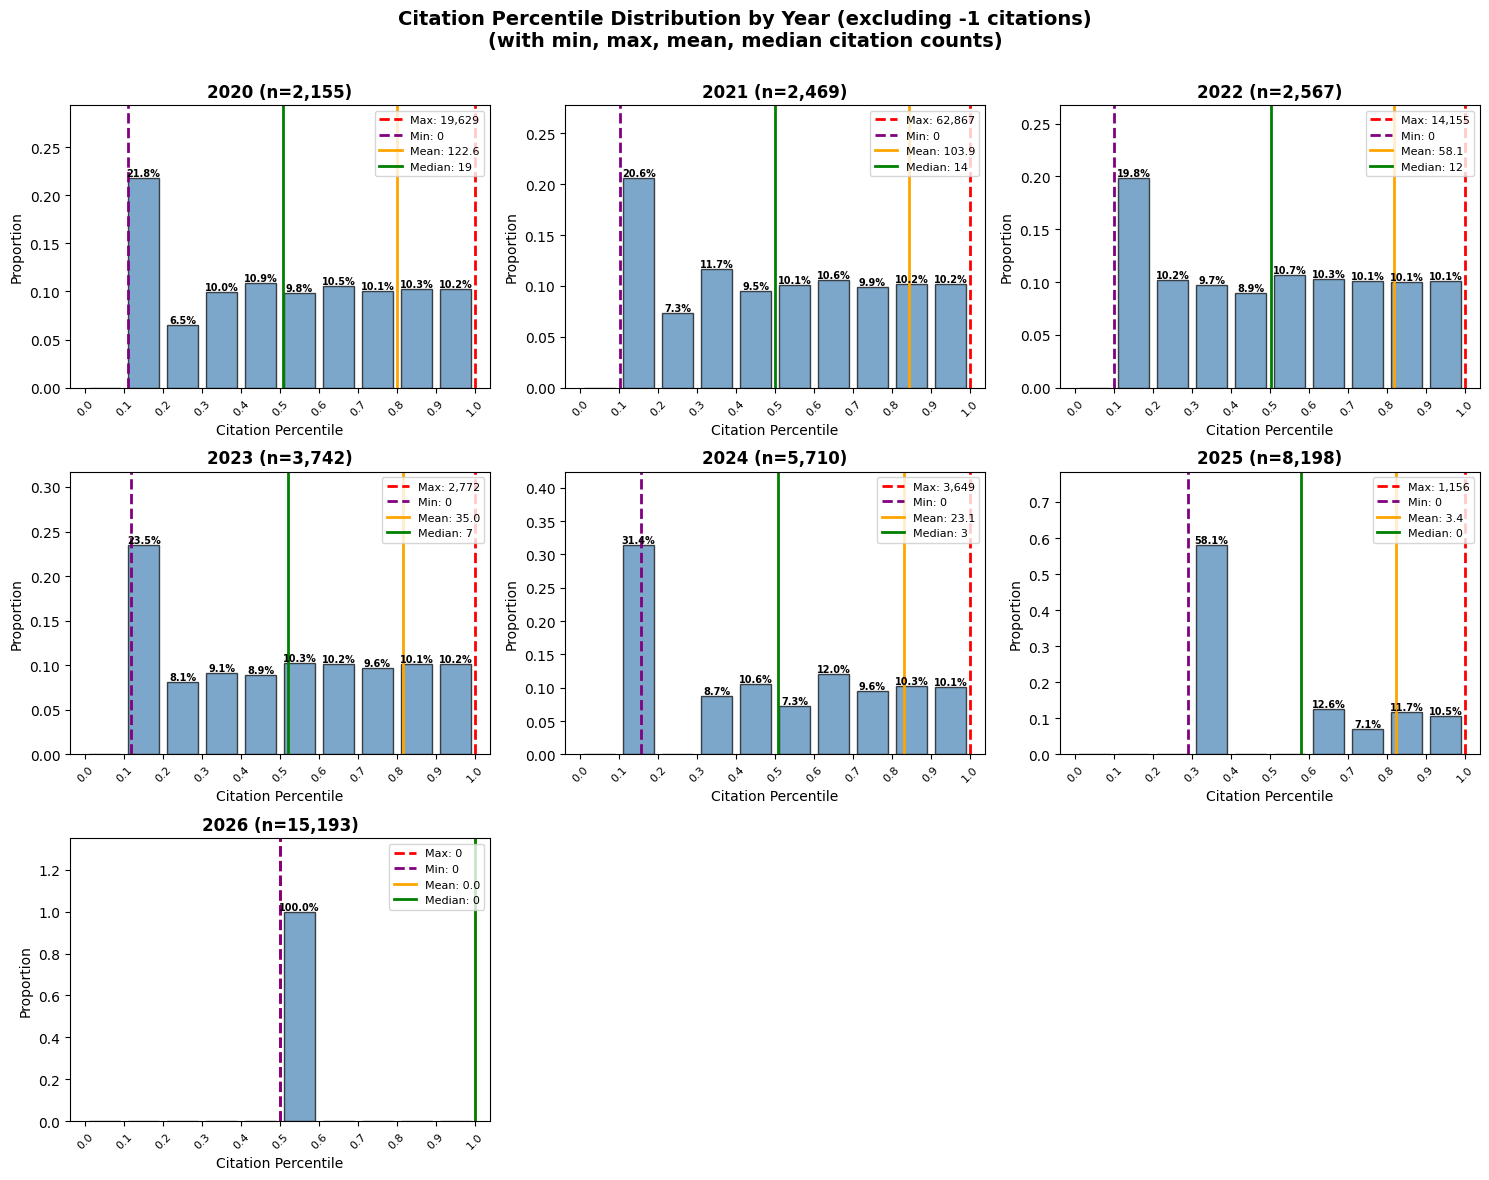

In [40]:
# Citation Percentile Distribution by Year (2020-2026)
# Each subplot shows histogram with vertical lines for min, max, mean, median citations
# Excludes papers with -1 citations (missing data)

years = [2020, 2021, 2022, 2023, 2024, 2025, 2026]
bins = np.arange(0, 1.1, 0.1)
bin_centers = bins[:-1] + 0.05

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, year in enumerate(years):
    ax = axes[idx]
    
    # Filter data for this year, excluding -1 citations
    year_df = df[(df['year'] == year) & (df['citations'] >= 0)].dropna(subset=['citations_normalized_by_year', 'citations'])
    citations_pct = year_df['citations_normalized_by_year']
    citations_raw = year_df['citations']
    
    if len(citations_pct) == 0:
        ax.text(0.5, 0.5, f'{year}\nNo data', ha='center', va='center', fontsize=14)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        continue
    
    # Compute histogram
    counts, _ = np.histogram(citations_pct, bins=bins)
    props = counts / len(citations_pct) if len(citations_pct) > 0 else counts
    
    # Plot histogram
    bars = ax.bar(bin_centers, props, width=0.08, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Add percentage labels above each bar
    for bar, prop in zip(bars, props):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{prop*100:.1f}%',
                    ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Compute stats (raw citations)
    min_cit = citations_raw.min()
    max_cit = citations_raw.max()
    mean_cit = citations_raw.mean()
    median_cit = citations_raw.median()
    
    # Find percentile positions for the vertical lines
    # Use the actual percentile position where each stat falls
    min_pct = (citations_raw <= min_cit).mean() / 2  # Midpoint of min ties
    max_pct = (citations_raw < max_cit).mean() + (citations_raw == max_cit).mean() / 2  # Midpoint of max ties
    mean_pct = (citations_raw <= mean_cit).mean()
    median_pct = (citations_raw <= median_cit).mean()
    
    # Add vertical lines at actual percentile positions
    ax.axvline(x=max_pct, color='red', linestyle='--', linewidth=2, label=f'Max: {max_cit:,.0f}')
    ax.axvline(x=min_pct, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_cit:,.0f}')
    ax.axvline(x=mean_pct, color='orange', linestyle='-', linewidth=2, label=f'Mean: {mean_cit:,.1f}')
    ax.axvline(x=median_pct, color='green', linestyle='-', linewidth=2, label=f'Median: {median_cit:,.0f}')
    
    # Labels
    ax.set_title(f'{year} (n={len(year_df):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Citation Percentile')
    ax.set_ylabel('Proportion')
    ax.set_xticks(bins)
    ax.set_xticklabels([f'{b:.1f}' for b in bins], rotation=45, fontsize=8)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_ylim(0, max(props) * 1.35 if len(props) > 0 and max(props) > 0 else 1)

# Hide unused subplots (8 and 9)
for idx in range(len(years), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Citation Percentile Distribution by Year (excluding -1 citations)\n(with min, max, mean, median citation counts)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [47]:
df

,submission_id,year,openreview_link,pdf_download_link,title,original_abstract,no_github_abstract,original_md_path,clean_md_path,images_in_clean_md,clean_pdf_img_paths,original_reviews,normalized_reviews,original_metareview,normalized_metareview,technical_indicators,metadata_of_changes,submission_json,content_list_json,_pdf_path,_mineru_path,_normalized_path,binary_decision,specific_decision,citations,ratings,citations_normalized_by_year,mean_rating,rating_normalized_by_year,acceptance,decision_encoded
0,ryxnJlSKvr,2020,https://openreview.net/forum?id=ryxnJlSKvr,https://openreview.net/pdf/b2abeae9a999f4f2f2f...,SCELMo: Source Code Embeddings from Language M...,Continuous embeddings of tokens in computer pr...,Continuous embeddings of tokens in computer pr...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,"{""2b0012e36586a72d787d752b4a0a2ce9a7f7ac7dfec7...","[""/n/fs/vision-mix/sk7524/NipsIclrData/AutoRev...","[{""rating"": ""3: Weak Reject"", ""review"": ""The p...","[""{\""summary\"":\""The paper applies ELMO embedd...","{""decision"": ""Reject"", ""comment"": ""This paper ...","""{\""summary\"":\""The paper is rejected due to i...","{""binary_decision"": ""reject"", ""specific_decisi...","{""submission_id"": ""ryxnJlSKvr"", ""year"": 2020, ...","{""id"": ""ryxnJlSKvr"", ""forum"": ""ryxnJlSKvr"", ""n...","[{""type"": ""text"", ""text"": ""1 INTRODUCTION"", ""t...",/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,reject,reject,63,"[3, 3, 8]",0.695632,4.666667,0.541401,0,0
1,ryxtWgSKPB,2020,https://openreview.net/forum?id=ryxtWgSKPB,https://openreview.net/pdf/e90a912a0f6b4596f6b...,Quantum Optical Experiments Modeled by Long Sh...,We demonstrate how machine learning is able to...,We demonstrate how machine learning is able to...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,"{""0acaeeb9acd241fef1465cdbbe564e71aaffd1eea521...","[""/n/fs/vision-mix/sk7524/NipsIclrData/AutoRev...","[{""rating"": ""3: Weak Reject"", ""review"": ""This ...","[""{\""summary\"":\""The paper proposes using mach...","{""decision"": ""Reject"", ""comment"": ""The paper p...","""{\""summary\"":\""The paper proposes using RNNs ...","{""binary_decision"": ""reject"", ""specific_decisi...","{""submission_id"": ""ryxtWgSKPB"", ""year"": 2020, ...","{""id"": ""ryxtWgSKPB"", ""forum"": ""ryxtWgSKPB"", ""n...","[{""type"": ""text"", ""text"": ""1 INTRODUCTION"", ""t...",/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,reject,reject,13,"[3, 1, 1]",0.477480,1.666667,0.052320,0,0
2,ryxsUySFwr,2020,https://openreview.net/forum?id=ryxsUySFwr,https://openreview.net/pdf/89002f34556ae166746...,Neural Network Out-of-Distribution Detection f...,Neural network out-of-distribution (OOD) detec...,Neural network out-of-distribution (OOD) detec...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,"{""1431b6dc9b7a54fa97731b30efa161623fe86a31846a...","[""/n/fs/vision-mix/sk7524/NipsIclrData/AutoRev...","[{""rating"": ""3: Weak Reject"", ""review"": ""The a...","[""{\""summary\"":\""The paper presents an empiric...","{""decision"": ""Reject"", ""comment"": ""The paper i...","""{\""summary\"":\""The paper investigates out-of-...","{""binary_decision"": ""reject"", ""specific_decisi...","{""submission_id"": ""ryxsUySFwr"", ""year"": 2020, ...","{""id"": ""ryxsUySFwr"", ""forum"": ""ryxsUySFwr"", ""n...","[{""type"": ""text"", ""text"": ""1 INTRODUCTION"", ""t...",/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,/n/fs/vision-mix/sk7524/NipsIclrData/AutoRevie...,reject,reject,3,"[3, 3, 1, 1]",0.344631,2.000000,0.077571,0,0
3,ryxnY3NYPS,2020,https://openreview.net/forum?id=ryxnY3NYP